# The Primary Goals of this Movie Recommendation Project are:
1. To develop a Movie Recommendation System using collaborative filtering techniques.
2. To analyze user rating patterns and identify similar users for personalized recommendations.
3. To create a User-Item Matrix for mapping user ratings to movies.
4. To leverage cosine similarity to measure user-user similarity.
5. To recommend movies that a user is likely to enjoy based on the preferences of other similar users.
6. To enhance user experience by delivering personalized and relevant movie suggestions.

**1. Importing the Libraries**

In [125]:
# Importing required libraries 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

# 

**2. Loading the Datasets**

In [126]:
movies = pd.read_csv("movies_new.csv",encoding='ISO-8859-1')

In [127]:
movies.columns

Index(['movie_id', 'title', 'genres'], dtype='object')

In [128]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [129]:
ratings = pd.read_csv("ratings_cleaned.csv")

In [130]:
ratings.head()

,user_id,movie_id,rating,timestamp,user_emb_id,movie_emb_id
0,1,1193,5,978300760,0,1192
1,1,661,3,978302109,0,660
2,1,914,3,978301968,0,913
3,1,3408,4,978300275,0,3407
4,1,2355,5,978824291,0,2354


In [131]:
ratings.columns

Index(['user_id', 'movie_id', 'rating', 'timestamp', 'user_emb_id',
       'movie_emb_id'],
      dtype='object')

# 

In [132]:
# Checking the missing values
movies.isnull().sum()

movie_id      0
title         0
genres      993
dtype: int64

In [133]:
movies.shape

(3883, 3)

In [134]:
movies.count()

movie_id    3883
title       3883
genres      2890
dtype: int64

In [135]:
ratings.count()

user_id         1000209
movie_id        1000209
rating          1000209
timestamp       1000209
user_emb_id     1000209
movie_emb_id    1000209
dtype: int64

# 

**3. Popularity-Based Recommendation System**

Recommend movies based on their average rating and number of ratings.

In [136]:
# Calculate average rating and count of ratings 
movie_stats = ratings.groupby("movie_id").agg({"rating":["mean","count"]}).reset_index()
movie_stats.columns = ["movie_id","avg_rating","rating_count"]

In [137]:
movie_stats

,movie_id,avg_rating,rating_count
0,1,4.146846,2077
1,2,3.201141,701
2,3,3.016736,478
3,4,2.729412,170
4,5,3.006757,296
...,...,...,...
3701,3948,3.635731,862
3702,3949,4.115132,304
3703,3950,3.666667,54
3704,3951,3.900000,40


In [138]:
# Merge with movies titles 
popular_movies = movie_stats.merge(movies,on="movie_id")

# Filtering movies with at least 50 ratings 
popular_movies = popular_movies[popular_movies["rating_count"]>50]

# Sorting the movies based on rating count
popular_movies = popular_movies.sort_values(by=["rating_count"],ascending=False)

In [139]:
popular_movies

,movie_id,avg_rating,rating_count,title,genres
2651,2858,4.317386,3428,American Beauty (1999),Comedy|Drama
253,260,4.453694,2991,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1106,1196,4.292977,2990,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1120,1210,4.022893,2883,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
466,480,3.763847,2672,Jurassic Park (1993),Action|Adventure|Sci-Fi
...,...,...,...,...,...
1601,1756,2.549020,51,Prophecy II,NaN
835,896,3.431373,51,Wild Reeds (1994),Drama
2796,3008,3.725490,51,Last Night (1998),Thriller
1323,1427,2.294118,51,Turbulence (1997),Thriller


In [140]:
# Top 10 popular movies 
print("Top 10 Popular Movies: ")
print(popular_movies[["title","avg_rating","rating_count"]].head(10))

Top 10 Popular Movies: 
                                                  title  avg_rating  \
2651                             American Beauty (1999)    4.317386   
253           Star Wars: Episode IV - A New Hope (1977)    4.453694   
1106  Star Wars: Episode V - The Empire Strikes Back...    4.292977   
1120  Star Wars: Episode VI - Return of the Jedi (1983)    4.022893   
466                                Jurassic Park (1993)    3.763847   
1848                         Saving Private Ryan (1998)    4.337354   
575                   Terminator 2: Judgment Day (1991)    4.058513   
2374                                             Matrix    4.315830   
1178                          Back to the Future (1985)    3.990321   
579                                Silence of the Lambs    4.351823   

      rating_count  
2651          3428  
253           2991  
1106          2990  
1120          2883  
466           2672  
1848          2653  
575           2649  
2374          2590  
1178 

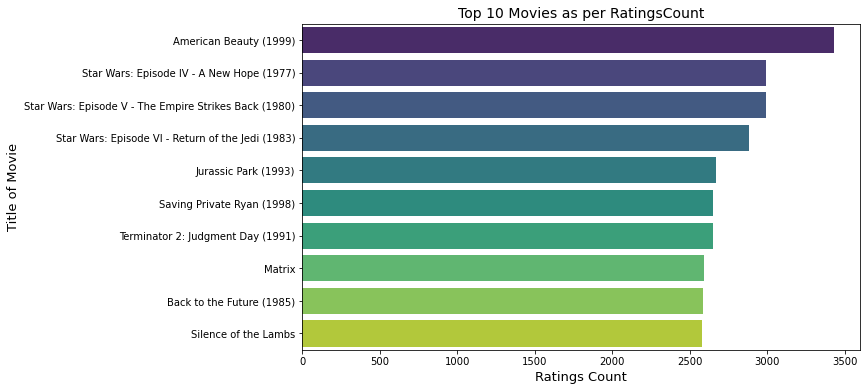

In [141]:
# Plotting the top10 movies as per ratingscount

top10 = popular_movies.head(10)
plt.figure(figsize=(10,6))
sns.barplot(y="title",x="rating_count",data=top10,palette="viridis")
plt.title("Top 10 Movies as per RatingsCount",fontsize=14)
plt.xlabel("Ratings Count",fontsize=13)
plt.ylabel("Title of Movie",fontsize=13)
plt.show()

# 

**4. Collaborative Filtering (User-Based)**

Recommend movies based on similar users’ preferences.

**4.1 Creating User-Item Matrix:**

In [142]:
# Create user-item matrix
user_movie_matrix = ratings.pivot_table(index='user_id', columns='movie_id', values='rating')

# Fill missing values with 0
user_movie_matrix_filled = user_movie_matrix.fillna(0)

# Display the user-item matrix
print("User-Item Matrix:")
print(user_movie_matrix_filled.head())

User-Item Matrix:
movie_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                               ...   
1          5.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5          0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   

movie_id  3943  3944  3945  3946  3947  3948  3949  3950  3951  3952  
user_id                                                               
1          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4          0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5          0.0  

**4.2 Compute User Similarity:**

In [143]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix_filled.index,
                                  columns=user_movie_matrix_filled.index)

print("User Similarity Matrix:")
print(user_similarity_df.head())

User Similarity Matrix:
user_id      1         2         3         4         5         6         7     \
user_id                                                                         
1        1.000000  0.096382  0.120610  0.132455  0.090158  0.179222  0.059678   
2        0.096382  1.000000  0.151479  0.171176  0.114394  0.100865  0.305787   
3        0.120610  0.151479  1.000000  0.151227  0.062907  0.074603  0.138332   
4        0.132455  0.171176  0.151227  1.000000  0.045094  0.013529  0.130339   
5        0.090158  0.114394  0.062907  0.045094  1.000000  0.047449  0.126257   

user_id      8         9         10    ...      6031      6032      6033  \
user_id                                ...                                 
1        0.138241  0.226148  0.255288  ...  0.170588  0.082006  0.069807   
2        0.203337  0.190198  0.226861  ...  0.112503  0.091222  0.268565   
3        0.077656  0.126457  0.213655  ...  0.092960  0.125864  0.161507   
4        0.100856  0.093651 

**4.3 Defining Function which will Recommend Movies for a User:**

In [144]:
# Function to recommend movies based on similar users
def recommend_movies(user_id, user_movie_matrix, user_similarity, movies, top_n=5):
    # Find similar users
    user_index = user_id - 1  # Assuming userId starts at 1
    similar_users = user_similarity[user_index]
    
    # Weighted ratings
    user_ratings = user_movie_matrix.loc[user_id]
    weighted_ratings = (similar_users @ user_movie_matrix.fillna(0)) / similar_users.sum()
    
    # Filter out already rated movies
    recommendations = pd.Series(weighted_ratings, index=user_movie_matrix.columns)
    recommendations = recommendations[user_ratings.isnull()]
    
    # Get top recommendations
    top_recommendations = recommendations.sort_values(ascending=False).head(top_n)
    recommended_movies = movies[movies['movie_id'].isin(top_recommendations.index)]
    
    return recommended_movies[['title', 'genres']]

# Recommendmovies for user 1
user_id = 1
print(f"Top 5 Recommendations for User {user_id}:")
print(recommend_movies(user_id, user_movie_matrix, user_similarity, movies))

Top 5 Recommendations for User 1:
                                                  title  \
589                                Silence of the Lambs   
1178  Star Wars: Episode V - The Empire Strikes Back...   
1180                     Raiders of the Lost Ark (1981)   
1192  Star Wars: Episode VI - Return of the Jedi (1983)   
2789                             American Beauty (1999)   

                                   genres  
589                                   NaN  
1178    Action|Adventure|Drama|Sci-Fi|War  
1180                     Action|Adventure  
1192  Action|Adventure|Romance|Sci-Fi|War  
2789                         Comedy|Drama  


# 

**5. Exploratory Data Analysis (EDA)**

5.1 Distribution of ratings

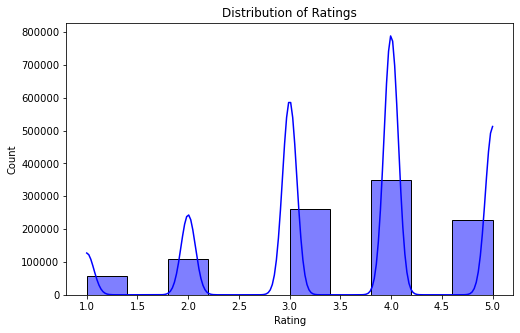

In [145]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.histplot(ratings['rating'], bins=10 , kde=True, color='blue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

5.2 Top Genres by Popularity

In [146]:
# Finding the most watched genre
movies["genres"].mode()

0    Drama
Name: genres, dtype: object

In [147]:
# Extract genres
movies['genres'] = movies['genres'].str.split('|')

# Count genres
all_genres = pd.DataFrame(movies['genres'].explode().value_counts().reset_index())
all_genres.columns = ['Genre', 'Count']


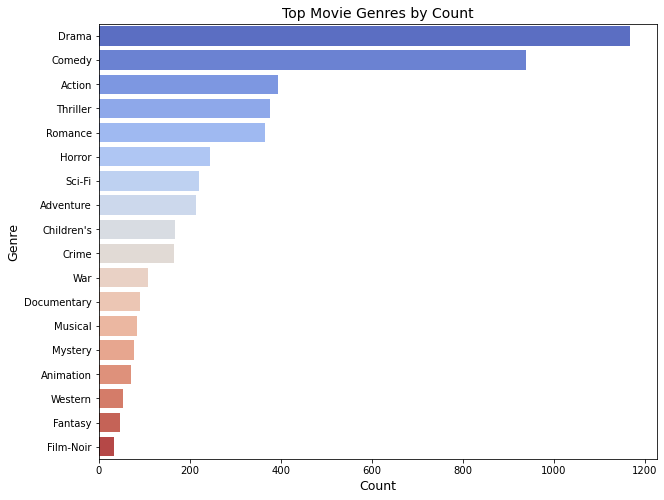

In [148]:
# Visualize top genres
plt.figure(figsize=(10, 8))
sns.barplot(x='Count', y='Genre', data=all_genres, palette='coolwarm')
plt.title('Top Movie Genres by Count',fontsize=14)
plt.xlabel('Count',fontsize=12.5)
plt.ylabel('Genre',fontsize=12.5)
plt.show()

# Conclusion

In this notebook, I demonstrated how to use a **user-based collaborative filtering approach** to build a recommendation engine for movie ratings. By **leveraging a User-Item Matrix and calculating cosine similarity between users**, this model **successfully provided personalized movie recommendations**. This approach effectively identifies similar users and suggests movies that align with the preferences of the target user, showcasing the power of collaborative filtering in recommendation systems.